In [1]:
# Standard lib imports
import itertools
from typing import Union, Tuple, Any

# Non-standard lib imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score

In [2]:
DATA_PATH = '../data/CreditScoring.csv'

In [3]:
df_credit_original = pd.read_csv(DATA_PATH)
df_credit_original.head()

,Status,Seniority,Home,Time,Age,Marital,Records,Job,Expenses,Income,Assets,Debt,Amount,Price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910


In [4]:
def string_transformations(
    target: Union[pd.core.strings.accessor.StringMethods, pd.core.indexes.base.Index]
) -> Union[pd.core.series.Series, pd.core.indexes.base.Index]:
    """
        Stage 1 cleaning for this churn prediction:
        - Lower case for everything
        - Spaces replaced by underscores

        Can work on either Pandas indices (e.g. column headers) or Pandas series (e.g. row data)
        
        :param StringMethods | Index target: the target row or column to standardise
        :return StringMethods | Index result: the standardised row or column

        Note the return types are using typing since this was written pre-3.10.
    """
    result = (
        target
        .str
        .lower()
        .str
        .replace(' ', '_')
    )

    return result

In [5]:
def get_column_maps() -> dict:
    status_map: dict = {
        0: 'unknown',
        1: 'ok',
        2: 'default'
    }

    home_map: dict = {
        0: 'unknown',
        1: 'rent',
        2: 'owner',
        3: 'private',
        4: 'ignore',
        5: 'parents',
        6: 'other'
    }

    marital_map: dict = {
        0: 'unknown',
        1: 'single',
        2: 'married',
        3: 'widow',
        4: 'separated',
        5: 'divorced'
    }

    records_map: dict = {
        0: 'unknown',
        1: 'yes',
        2: 'no'
    }

    job_map: dict = {
        0: 'unknown',
        1: 'fixed',
        2: 'parttime',
        3: 'freelance',
        4: 'others'
    }

    maps: dict = {
        'status': status_map,
        'home': home_map,
        'marital': marital_map,
        'records': records_map,
        'job': job_map
    }

    return maps

def map_columns(maps: dict, df: pd.DataFrame) -> pd.DataFrame:
    df_new = df.copy()

    mapped_col_keys: list = list(maps.keys())
    mapped_col_keys, df_new.columns

    df_new[mapped_col_keys] = df_new[mapped_col_keys].apply(lambda series: map_column(maps.get(series.name), series))
    
    return df_new

def map_column(map: dict, column: pd.Series) -> pd.Series:
    if map is not None:
        result = column.map(map)

    return result

def remove_max(cols: list[str], df: pd.DataFrame) -> pd.DataFrame:
    df_new = df.copy()

    df_new[cols] = df_new[cols].replace(to_replace=99999999, value=np.nan)

    return df_new

def encode_labels(df: pd.DataFrame, col_name: str, encode_value: str) -> np.ndarray:
    encoded_col = (df[col_name] == encode_value).astype(int).values

    return encoded_col

In [6]:
df_credit_transformed = df_credit_original.copy()
df_credit_transformed.columns = string_transformations(target=df_credit_transformed.columns)
df_credit_transformed = map_columns(maps=get_column_maps(), df=df_credit_transformed)
df_credit_transformed = remove_max(['income', 'assets', 'debt'], df_credit_transformed)
df_credit_transformed = df_credit_transformed[df_credit_transformed['status'] != 'unknown']
df_credit_transformed = df_credit_transformed.reset_index(drop=True)

In [7]:
df_credit_transformed.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4454.0,4454.0,4454.0,4454.0,4420.0,4407.0,4436.0,4454.0,4454.0
mean,8.0,46.0,37.0,56.0,131.0,5404.0,343.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,86.0,11574.0,1246.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1117.0
50%,5.0,48.0,36.0,51.0,120.0,3000.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,165.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,959.0,300000.0,30000.0,5000.0,11140.0


In [8]:
df_credit_transformed.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,ok,9,rent,60,30,married,yes,freelance,73,129.0,0.0,0.0,800,846
1,ok,17,rent,60,58,widow,yes,fixed,48,131.0,0.0,0.0,1000,1658
2,default,10,owner,36,46,married,no,freelance,90,200.0,3000.0,0.0,2000,2985
3,ok,0,rent,60,24,single,yes,fixed,63,182.0,2500.0,0.0,900,1325
4,ok,0,rent,36,26,single,yes,fixed,46,107.0,0.0,0.0,310,910


In [9]:
df_full_train, df_test = train_test_split(df_credit_transformed, test_size=0.2, random_state=11) # 11 from the video to reproduce results
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=11) # same

In [10]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = encode_labels(df=df_train, col_name='status', encode_value='default')
y_val = encode_labels(df=df_val, col_name='status', encode_value='default')
y_test = encode_labels(df=df_test, col_name='status', encode_value='default')

del df_train['status']
del df_val['status']
del df_test['status']

In [11]:
dict_train = df_train.fillna(0).to_dict(orient='records')
vect = DictVectorizer(sparse=False)
X_train = vect.fit_transform(dict_train)
X_train, vect.get_feature_names_out()

(array([[3.60e+01, 1.00e+03, 1.00e+04, ..., 1.00e+00, 1.00e+01, 3.60e+01],
        [3.20e+01, 1.10e+03, 0.00e+00, ..., 0.00e+00, 6.00e+00, 4.80e+01],
        [4.00e+01, 1.32e+03, 0.00e+00, ..., 1.00e+00, 1.00e+00, 4.80e+01],
        ...,
        [1.90e+01, 4.00e+02, 0.00e+00, ..., 1.00e+00, 1.00e+00, 2.40e+01],
        [4.30e+01, 2.50e+03, 1.80e+04, ..., 1.00e+00, 1.50e+01, 4.80e+01],
        [2.70e+01, 4.50e+02, 5.00e+03, ..., 0.00e+00, 1.20e+01, 4.80e+01]]),
 array(['age', 'amount', 'assets', 'debt', 'expenses', 'home=ignore',
        'home=other', 'home=owner', 'home=parents', 'home=private',
        'home=rent', 'home=unknown', 'income', 'job=fixed',
        'job=freelance', 'job=others', 'job=parttime', 'job=unknown',
        'marital=divorced', 'marital=married', 'marital=separated',
        'marital=single', 'marital=unknown', 'marital=widow', 'price',
        'records=no', 'records=yes', 'seniority', 'time'], dtype=object))

In [12]:
dec_tree = DecisionTreeClassifier(max_depth=3)
dec_tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3)

In [13]:
dict_val = df_val.fillna(0).to_dict(orient='records')
X_val = vect.transform(dict_val)
y_val_pred = dec_tree.predict_proba(X_val)[:, 1] # Need to take first column or roc_auc_score will have a fit
y_train_pred = dec_tree.predict_proba(X_train)[:, 1]

In [14]:
roc_auc_score(y_val, y_val_pred), roc_auc_score(y_train, y_train_pred)

(0.7389079944782155, 0.7761016984958594)

In [15]:
print(export_text(dec_tree, feature_names=vect.feature_names_))

|--- records=no <= 0.50
|   |--- job=parttime <= 0.50
|   |   |--- income <= 74.50
|   |   |   |--- class: 0
|   |   |--- income >  74.50
|   |   |   |--- class: 0
|   |--- job=parttime >  0.50
|   |   |--- assets <= 8750.00
|   |   |   |--- class: 1
|   |   |--- assets >  8750.00
|   |   |   |--- class: 0
|--- records=no >  0.50
|   |--- seniority <= 6.50
|   |   |--- amount <= 862.50
|   |   |   |--- class: 0
|   |   |--- amount >  862.50
|   |   |   |--- class: 1
|   |--- seniority >  6.50
|   |   |--- income <= 103.50
|   |   |   |--- class: 1
|   |   |--- income >  103.50
|   |   |   |--- class: 0



In [16]:
def assess_dec_tree_candidate(max_depth: int, samples_leaf: int, X_train: np.ndarray, y_train: np.ndarray, X_val: np.ndarray, y_val: np.ndarray) -> float:
    dec_tree_kwargs = {}

    if max_depth is not None:
        dec_tree_kwargs['max_depth'] = max_depth
    
    if samples_leaf is not None:
        dec_tree_kwargs['min_samples_leaf'] = samples_leaf

    dec_tree_candidate: DecisionTreeClassifier = DecisionTreeClassifier(**dec_tree_kwargs)

    dec_tree_candidate.fit(X_train, y_train)

    y_pred = dec_tree_candidate.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)

    return auc

In [17]:
# Time to assess different feature sets for decision tree purity
depth_candidates: list[int] = [1, 2, 3, 4, 5, 6, 10, 15, 20, None]
for next_depth in depth_candidates:
    next_score = assess_dec_tree_candidate(max_depth=next_depth, samples_leaf=None, X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val)
    print("Depth: %4s, Score: %.3f" % (next_depth, next_score))
    

Depth:    1, Score: 0.606
Depth:    2, Score: 0.669
Depth:    3, Score: 0.739
Depth:    4, Score: 0.761
Depth:    5, Score: 0.767
Depth:    6, Score: 0.746
Depth:   10, Score: 0.684
Depth:   15, Score: 0.671
Depth:   20, Score: 0.667
Depth: None, Score: 0.661


In [18]:
# From the above, the best depths are 4, 5 and 6
# Do another assessment with other parameters
narrowed_depth_candidates: list[int] = [4, 5, 6]
samples_leaf_candidates: list[int] = [1, 2, 5, 10, 15, 20, 100, 200, 500]
assessment_candidates: itertools.product = itertools.product(narrowed_depth_candidates, samples_leaf_candidates)
scores = []

for next_depth, next_leaf in assessment_candidates:
    next_score = assess_dec_tree_candidate(max_depth=next_depth, samples_leaf=next_leaf, X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val)
    scores.append((next_depth, next_leaf, next_score))

df_scores = pd.DataFrame(scores, columns=['depth', 'samples_leaf', 'score'])

In [19]:
#df_scores.sort_values(by="score", ascending=False)
df_scores_pivot = df_scores.pivot(index="samples_leaf", columns=["depth"], values="score")
df_scores_pivot = df_scores_pivot.round(3)

<AxesSubplot: xlabel='depth', ylabel='samples_leaf'>

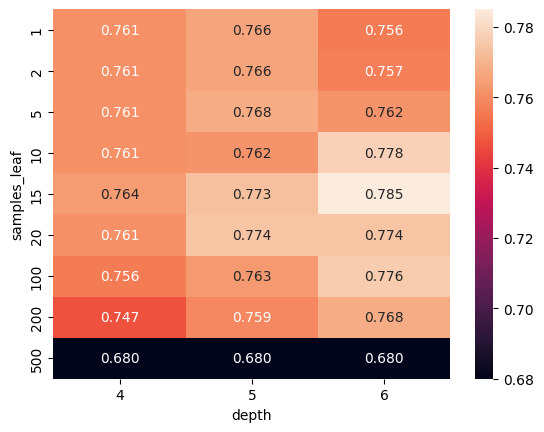

In [20]:
sns.heatmap(df_scores_pivot, annot=True, fmt=".3f")

In [21]:
# Video shows that there's actually a more optimal depth/leaf combo
# But they decide not to bother with that - max depth 6, min samples leaf 15
# Stick with that
dec_tree_final = DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)
dec_tree_final.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)

In [22]:
# Now to compare against random forest!
rf_classifier: RandomForestClassifier = RandomForestClassifier(n_estimators=10, random_state=1)
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(n_estimators=10, random_state=1)

In [23]:
y_rf_pred = rf_classifier.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_rf_pred)

0.7823799375166502

In [32]:
def assess_random_forest_candidate(n_estimators: int, max_depth: int, samples_leaf: int, X_train: np.ndarray, y_train: np.ndarray, X_val: np.ndarray, y_val: np.ndarray) -> float:
    rf_kwargs = {}

    if max_depth is not None:
        rf_kwargs['max_depth'] = max_depth
    
    if n_estimators is not None:
        rf_kwargs['n_estimators'] = n_estimators

    if samples_leaf is not None:
        rf_kwargs['min_samples_leaf'] = samples_leaf

    random_forest_candidate: RandomForestClassifier = RandomForestClassifier(random_state=1, **rf_kwargs)

    random_forest_candidate.fit(X_train, y_train)

    y_pred = random_forest_candidate.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)

    return auc

In [25]:
rf_scores = []

for next_est in range(10, 201, 10):
    score = assess_random_forest_candidate(n_estimators=next_est, max_depth=None, samples_leaf=None, X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val)
    rf_scores.append((next_est, score))

df_rf_scores = pd.DataFrame(rf_scores, columns=['n_estimators', 'score'])

In [26]:
df_rf_scores

,n_estimators,score
0,10,0.782380
1,20,0.803023
2,30,0.811421
3,40,0.814070
4,50,0.817036
5,60,0.818120
6,70,0.816056
7,80,0.817981
8,90,0.819861
9,100,0.821935


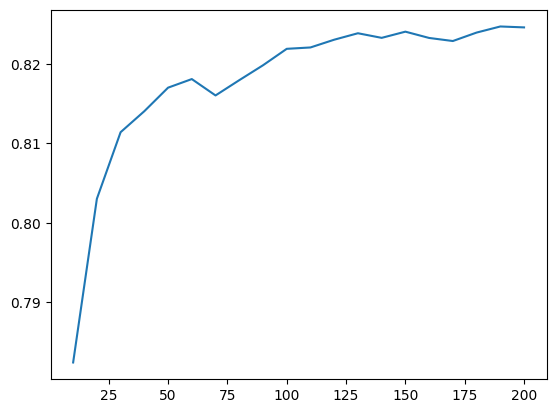

In [27]:
plt.plot(df_rf_scores['n_estimators'], df_rf_scores['score'])

In [28]:
# Same again but with a max_depth parameter introduced
rf_max_depth_candidates: list[int] = [5, 10, 15]
rf_n_estimators_candidates: list[int] = [x for x in range(10, 201, 10)]
rf_assessment_candidates: itertools.product = itertools.product(rf_max_depth_candidates, rf_n_estimators_candidates)
rf_new_scores = []

for next_rf_depth, next_rf_est in rf_assessment_candidates:
    rf_candidate_score = assess_random_forest_candidate(n_estimators=next_rf_est, max_depth=next_rf_depth, samples_leaf=None, X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val)
    rf_new_scores.append((next_rf_depth, next_rf_est, rf_candidate_score))

df_rf_new_scores = pd.DataFrame(rf_new_scores, columns=['depth', 'estimators', 'score'])

In [30]:
df_rf_new_scores.sort_values('score', ascending=False).head()

,depth,estimators,score
24,10,50,0.825110
39,10,200,0.825001
23,10,40,0.824838
25,10,60,0.824771
38,10,190,0.824462


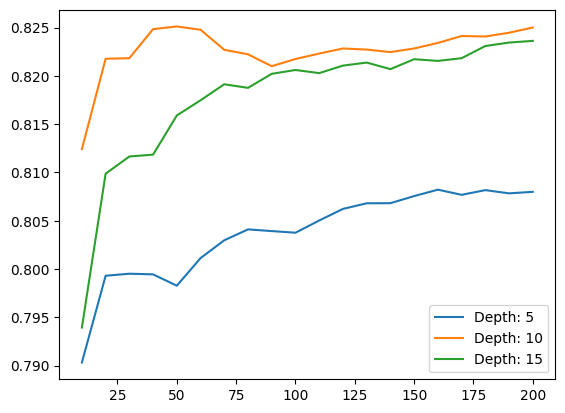

In [31]:
for next_depth in rf_max_depth_candidates:
    df_rf_subset: pd.DataFrame = df_rf_new_scores[df_rf_new_scores['depth'] == next_depth]
    plt.plot(df_rf_subset['estimators'], df_rf_subset['score'], label="Depth: %d" % next_depth)

plt.legend()

In [40]:
# Max depth of 10 is clearly the best performer
# Now run everything again, lock in depth of 10, but add min_samples_leaf
# That set of loops probably needs to be its own function but for the sake of time...
rf_locked_max_depth = 10
rf_locked_depth_min_samples_leaf_candidates: list[int] = [1, 3, 5, 10, 50]
rf_locked_depth_n_estimators_candidates: list[int] = [x for x in range(10, 201, 10)]
rf_locked_depth_assessment_candidates: itertools.product = itertools.product(rf_locked_depth_min_samples_leaf_candidates, rf_locked_depth_n_estimators_candidates)

rf_locked_depth_scores = []
for next_rf_leaf, next_rf_est in rf_locked_depth_assessment_candidates:
    rf_locked_depth_candidate_score = assess_random_forest_candidate(n_estimators=next_rf_est, max_depth=rf_locked_max_depth, samples_leaf=next_rf_leaf, X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val)
    rf_locked_depth_scores.append((next_rf_leaf, next_rf_est, rf_locked_depth_candidate_score))

df_locked_depth_scores = pd.DataFrame(rf_locked_depth_scores, columns=['leaf', 'estimators', 'score'])

In [41]:
df_locked_depth_scores.sort_values('score', ascending=False).head()

,leaf,estimators,score
39,3,200,0.826285
37,3,180,0.825631
38,3,190,0.825582
36,3,170,0.825570
35,3,160,0.825455


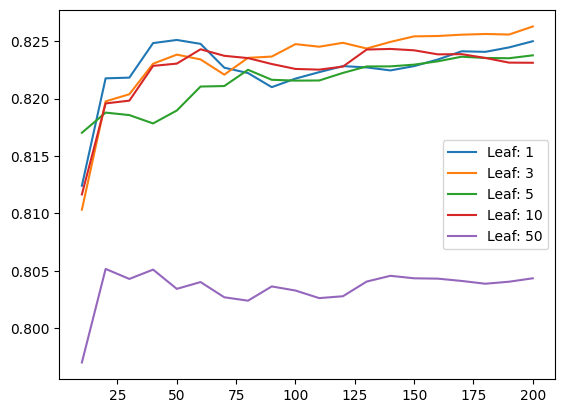

In [42]:
for next_leaf in rf_locked_depth_min_samples_leaf_candidates:
    df_rf_subset: pd.DataFrame = df_locked_depth_scores[df_locked_depth_scores['leaf'] == next_leaf]
    plt.plot(df_rf_subset['estimators'], df_rf_subset['score'], label="Leaf: %d" % next_leaf)

plt.legend()

In [43]:
# That decides it then - max depth of 10, min samples leaf of 3, n_estimators of 100
rf_final = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_leaf=3, random_state=1, n_jobs=-1)
rf_final.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=3, n_jobs=-1,
                       random_state=1)

In [ ]:
# Now, onto Gradient Boosting...